# **A Transformer-based Approach to Counteracting Online Misinformation**

**Team:**
* Jeff Oxenberg
* Cheng-Yi (Aaron) Tsai

**Course:** DAAN 570 – Deep Learning (Fall, 2021)

### Problem Statement
The relative ease by which information can be published, whether via social media platforms or on independent websites has created a revolution within the publishing industry, whereby many individuals no longer rely on content produced by a small set of trusted news organizations.  Additionally, the speed at which information travels has substantially increased, with a much greater potential reach.  Although this can generally be seen as a good thing, a significant challenge has arisen: combating the spread of misinformation.  Misinformation may take many forms, but in this case, we choose to focus on misinformation as provided via long-form articles published on the internet.  We use open-source datasets from reputable organizations to create a binary classifier in an attempt to detect misinformation in news articles and use explainability techniques to understand the performance of the model.

Many current approaches to identifying online misinformation require completely manual flagging and review, either by the community, by a team employed by the platform itself, by a third-party organization, or a combination of the above. This paradigm suffers from several challenges, primarily centered around the difficulty scaling a human-focused flagging process to a very large audience. The number of new posts on a large platform is so great that manual labeling and review of news articles poses significant labor challenges, such that by the time a post is removed or labeled as potential misinformation, it could have already reached a significant amount of people, potentially perpetuating untrue information. To help solve these scale challenges, we propose a deep-learning-based approach to augment the discovery and labeling of fake news.
    
* **Keywords:** Misinformation, Fake News Detection, BERT, Transformers

### Data Collection
* Source(url): https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php
* Short Description : This dataset is provided by University of Victoria ISOT lab, H. Ahmed, I. Traore and S. Saad, "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques," Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments, vol. 10618, pp. 127-138, 2017.

* Keywords: Fake News detection

* Source(url): https://github.com/KaiDMML/FakeNewsNet
* Short Description : K. Shu, D. Mahudeswaran, S. Wang, D. Lee and H. Liu, "FakeNewsNet: A Data Repository with News Content, Social Context, and Spatiotemporal Information for Studying Fake News on Social Media," Big Data, vol. 8, no. 3, pp. 171-188, 1 June 2020.

* Keywords: Fake News detection

## **Install and import required packages**

We're using Huggingface transformers, a python package that allows us to easily access state of the art NLP models for fine-tuning

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 57.7 MB/s 
     |████████████████████████████████| 596 kB 69.2 MB/s 
     |████████████████████████████████| 3.3 MB 58.0 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import seaborn as sns
from bs4 import BeautifulSoup
import re,string,unicodedata
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

## **Download, unzip, and preprocess main data set**

As the main data set, we are using a dataset provided by the University of Victoria's Information Security and Object Technology (ISOT) lab, that provides two CSV files: True (indicating the news articles are true) and Fake (indicating that the articles are not truthful).

In [ ]:
!gdown --id 1IoTRrJNDJqvaG3hnUpnHQyGvPAJbO8y3

Downloading...
From: https://drive.google.com/uc?id=1IoTRrJNDJqvaG3hnUpnHQyGvPAJbO8y3
To: /content/News _dataset.zip
100% 43.1M/43.1M [00:00<00:00, 56.3MB/s]


In [ ]:
!unzip /content/News\ _dataset.zip

Archive:  /content/News _dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
true = pd.read_csv('/content/True.csv')

In [ ]:
fake = pd.read_csv('/content/Fake.csv')

In [ ]:
true['label'] = 0
fake['label'] = 1

In [ ]:
print(len(true), len(fake))

21417 23481


In [ ]:
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


Notice all True instances appear to have a very similar pattern (STATE (Reuters)), we should remove this because it will cause label leakage

In [ ]:
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
true.groupby('subject').describe()

label                                   
                count mean  std  min  25%  50%  75%  max
subject                                                 
politicsNews  11272.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
worldnews     10145.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
fake.groupby('subject').describe()

label                                   
                  count mean  std  min  25%  50%  75%  max
subject                                                   
Government News  1570.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Middle-east       778.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
News             9050.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
US_News           783.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
left-news        4459.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
politics         6841.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

Notice that the 'subject' is also a source of leakage: subjects do not overlap between True vs Fake datasets, so we should remove subject as well.  We can also remove the Date feature, as the labels are not evenly distributed over the same time period

In [ ]:
true['text'] = true.text.str.replace(r'^.+\s\(Reuters\)\s-\s', '', regex=True)

In [ ]:
true.drop(['date', 'subject'], axis=1, inplace=True)
fake.drop(['date', 'subject'], axis=1, inplace=True)

Shuffle and combine the labeled datasets into one dataframe

In [ ]:
data = shuffle(pd.concat([true, fake]), random_state=42)

In [ ]:
data.head()

,title,text,label
799,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",1
6500,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,1
3590,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,1
1377,California AG pledges to defend birth control ...,California Attorney General Xavier Becerra sai...,0
11059,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


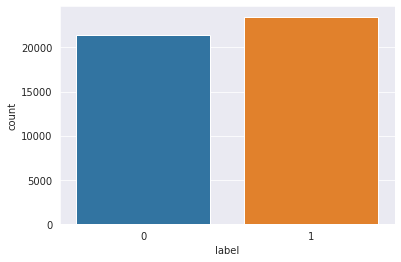

In [ ]:
sns.set_style("darkgrid")
sns.countplot(data.label)

In [ ]:
data.isna().sum() # Checking for nan Values

title    0
text     0
label    0
dtype: int64

In [ ]:
data.title.count()

44898

In [ ]:
data.title.value_counts()

Factbox: Trump fills top jobs for his administration                                                     14
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
Factbox: Contenders for senior jobs in Trump's administration                                             8
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
                                                                                                         ..
Magnitude 6.2 quake hits southeast of Oaxaca, Mexico: USGS                                                1
Mattis says U.S. effort on North Korea aims for diplomatic solution                                       1
Pence says his private email use was not the same as Clinton's                                            1
AMAZING ENTRANCE! Trump Does

Note that there are some duplicates; we clean this later in the larger dataset

## Data Preprocessing

* Remove stopwords, use DistilBERT tokenizer to create embeddings: pad sequences shorter than 512 and truncate sequences longer than 512


## **Data Cleaning**

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
data['text']=data['text'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=J4LjxrOfEF8" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=YeDU6dCR9tA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?time_continue=2&v=IjWClQcKhD8" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL

## **Wordcloud**

**Wordcloud for Fake News**

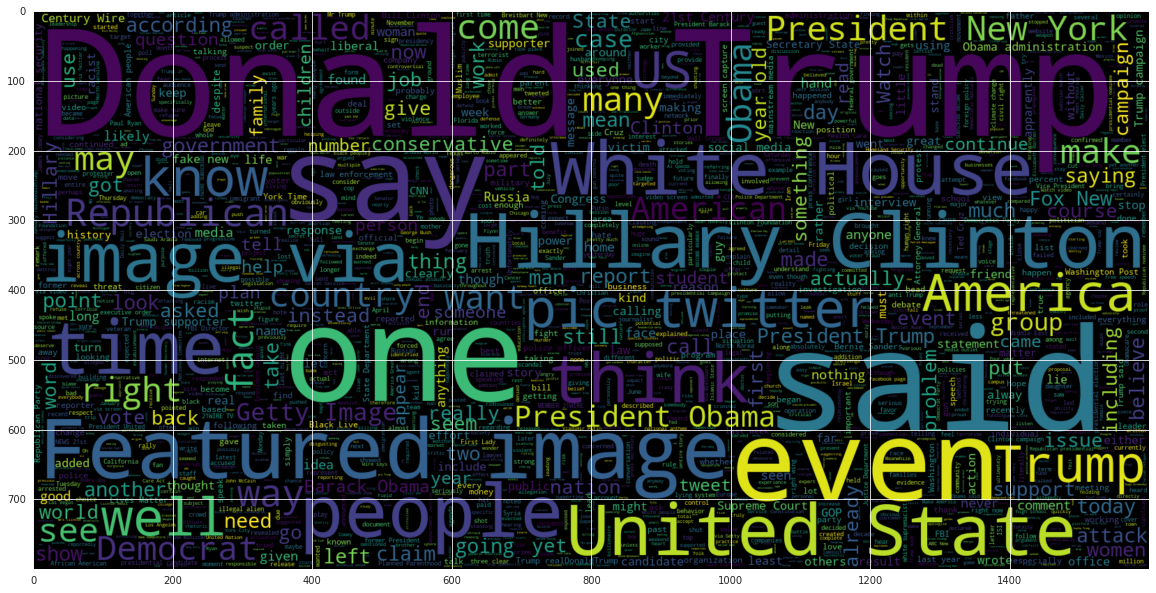

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**Wordcloud for True News**

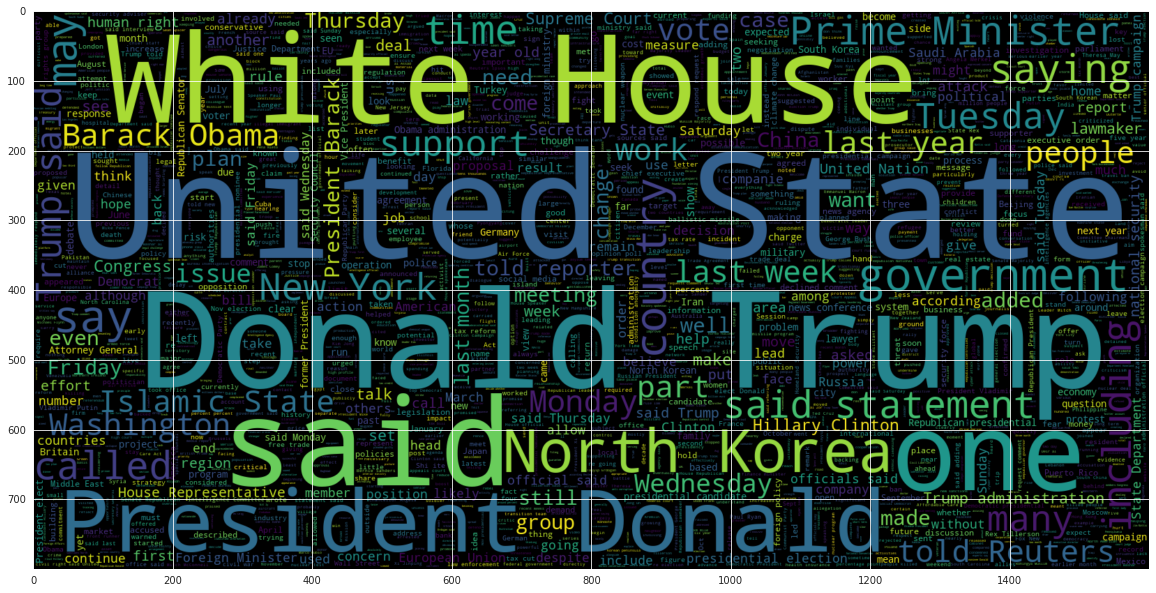

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

## **N-Gram Analysis**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

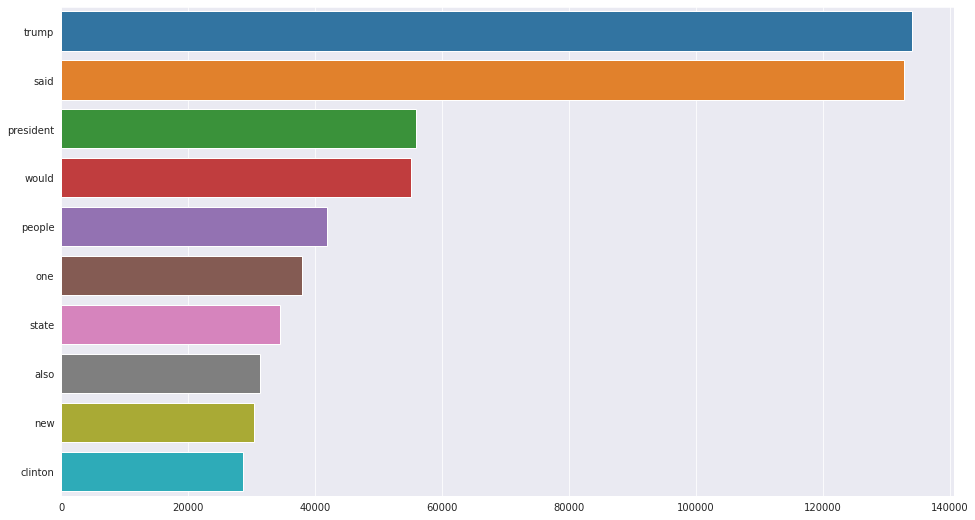

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(data.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

 **Bigram Analysis**

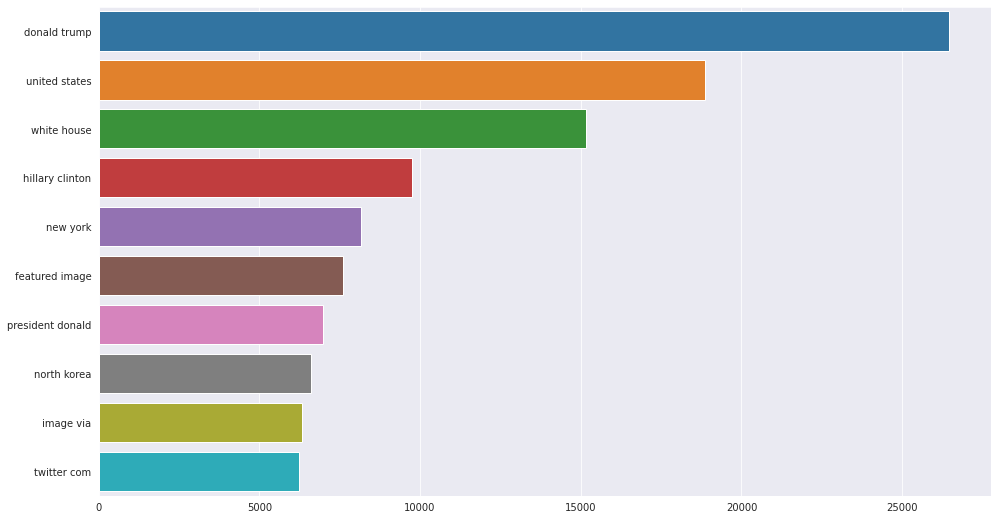

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

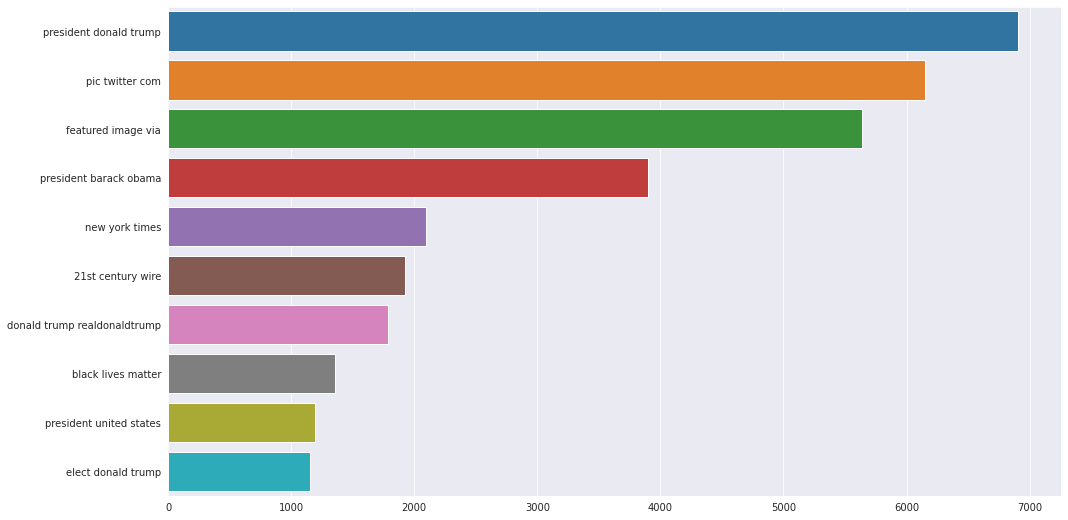

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(data.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

## Methodology

* 80:20 train/test split for each dataset
* We focus on the text of each article, and not the title or related metadata
* Test each dataset separately and then combine all datasets to test one larger corpus
* Introduce explainability techniques to understand why the model made a decision
* Current SOTA for many text classification benchmarks are transformer-based architectures
* We choose to fine-tune DistilBERT for this use case
*Ease of training (40% smaller than BERT with accuracy reduction of only 0.6% for binary classification) [9]

**Keywords:** natural language processing, classification, transformers

## **Model fitting and validation**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.2, random_state=42)

Import tokenizer; we use the Huggingface library to import the distilbert-base-uncased tokenizer, which tokenizes our sentence with the correct tokens for our distilbert model

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenize both train and test datasets, and then convert them to Tensorflow Datasets.  For inference, we can use a pipeline to combine the tokenizer with the model and avoid this step, as shown in a later section.

In [ ]:
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_list()
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.to_list()
))

Import the pre-trained distilbert-base-uncased model for Sequence Classification.  We compile the model using Adam optimizer with an initial learning rate of 5e-5, and we rely on the default choice for the model's loss function (model.compute_loss).  In this case, the creators of the Huggingface transformers library have suggested SparseCategoricalCrossentropy, which works well.

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy']) # can also use any keras loss fn
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16), validation_batch_size=16)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
2245/2245 [==============================] - 1300s 575ms/step - loss: 0.0270 - accuracy: 0.9905 - val_loss: 0.0130 - val_accuracy: 0.9957
Epoch 2/3
2245/2245 [==============================] - 1288s 574ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 3/3
2245/2245 [==============================] - 1288s 574ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.0082 - val_accuracy: 0.9981


In [ ]:
model_summaries = {'isot': {'accuracy': history.history['val_accuracy'], 'loss': history.history['val_loss']}}

## **Model evaluation**

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Here, we see the accuracy and loss plots

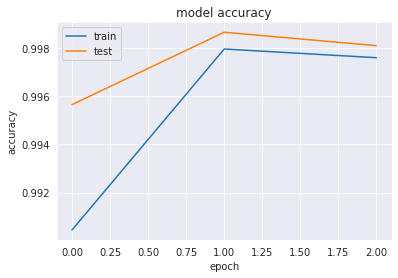

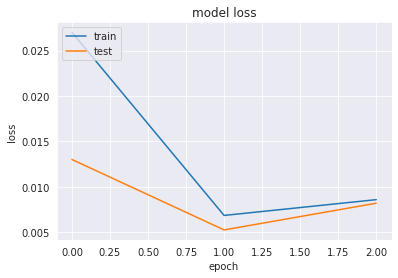

In [ ]:
plot_accuracy(history)

We compute the predictions for our entire test set.  The model returns logits instead of probabilities, so we convert those logits to a probability vector and compare them with their labels to compile a classification report and confusion matrix 

In [ ]:
Y_pred = model.predict(test_dataset.batch(1), batch_size=1)

In [ ]:
y_pred = [tf.round(tf.nn.sigmoid(x).numpy().argmax()) for x in Y_pred['logits']]

In [ ]:
print('Classification Report')
target_names = ['real', 'fake']
print(classification_report(y_test.to_list(), y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        real       1.00      1.00      1.00      4311
        fake       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



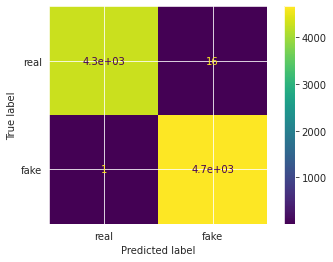

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test.to_list(), y_pred), display_labels=target_names)
disp.plot(values_format='')

We see that the performance is almost perfect!  There are only a few misclassifications as evidenced by the confusion matrix above.  Even after removing several leakages from the dataset, we still achieve almost perfect performance.  This seems too good to be true; let's try adding more datasets to the model, and then introduce an explainability technique to understand how our model makes decisions.

Normally, we would perform hyperparameter tuning, and additionally try other model architectures.  However, it seems that our problem is not with model or hyperparameter selection, but rather with dataset quality, so we omit tuning hyperparameters and model architecture in favor of adding a larger and more diverse corpus.

## **Add more datasets and train on each individually**

We add data from the FakeNewsNet dataset.  This dataset is "live" in that the creators (Arizona State University) provide links to the live articles and require that they be crawled to generate the corpus.  As such, we encountered many dead links, especially in data classified as "fake".  Logically, this is to be expected as we can assume "fake" news to be more ephemeral than "real" news, that is it would not remain available on the internet for as long.

We run the crawling script provided by FakeNewsNet, and write a function (Appendix A) to parse each article and generate a unified corpus.  FakeNewsNet contains both real and fake articles from two sources: Gossipcop and Politifact.

In [ ]:
!unzip /content/FakeNewsNet.zip

Archive:  /content/FakeNewsNet.zip
replace FakeNewsNet/gossipcop/fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace FakeNewsNet/gossipcop/real.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace FakeNewsNet/politifact/fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace FakeNewsNet/politifact/real.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### FakeNewsNet (Politifact)

In [ ]:
politifact_fake = pd.read_csv('/content/FakeNewsNet/politifact/fake.csv', names=['title', 'text'])
politifact_true = pd.read_csv('/content/FakeNewsNet/politifact/real.csv', names=['title', 'text'])

In [ ]:
politifact_fake.dropna(inplace=True)
politifact_true.dropna(inplace=True)
politifact_true['label'] = 0
politifact_fake['label'] = 1
politifact_data = shuffle(pd.concat([politifact_true, politifact_fake]), random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(politifact_data.text, politifact_data.label, test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_list()
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_test.to_list()
))

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy']) # can also use any keras loss fn
history = model.fit(train_dataset.shuffle(100).batch(16), epochs=4, batch_size=16, validation_data=test_dataset.shuffle(100).batch(16), validation_batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/4
41/41 [==============================] - 31s 603ms/step - loss: 0.4986 - accuracy: 0.7697 - val_loss: 0.2574 - val_accuracy: 0.8765
Epoch 2/4
41/41 [==============================] - 23s 570ms/step - loss: 0.1890 - accuracy: 0.9320 - val_loss: 0.3672 - val_accuracy: 0.8519
Epoch 3/4
41/41 [==============================] - 23s 570ms/step - loss: 0.1083 - accuracy: 0.9552 - val_loss: 0.2575 - val_accuracy: 0.9136
Epoch 4/4
41/41 [==============================] - 23s 570ms/step - loss: 0.0357 - accuracy: 0.9907 - val_loss: 0.2800 - val_accuracy: 0.9198


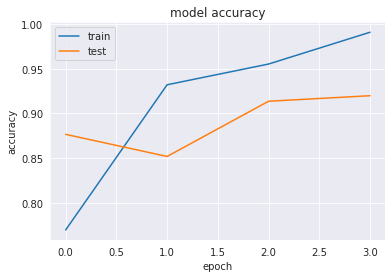

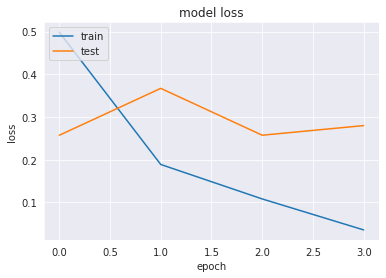

In [ ]:
plot_accuracy(history)

In [ ]:
Y_pred = model.predict(test_dataset.batch(1), batch_size=1)
y_pred = [tf.round(tf.nn.sigmoid(x).numpy().argmax()) for x in Y_pred['logits']]

In [ ]:
print('Classification Report')
target_names = ['real', 'fake']
print(classification_report(y_test.to_list(), y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        real       0.92      0.96      0.94       102
        fake       0.93      0.85      0.89        60

    accuracy                           0.92       162
   macro avg       0.92      0.91      0.91       162
weighted avg       0.92      0.92      0.92       162



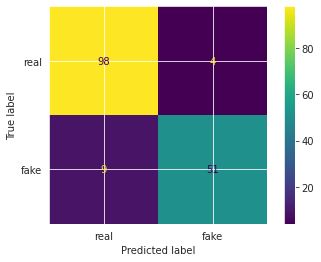

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test.to_list(), y_pred), display_labels=target_names)
disp.plot(values_format='')

In [ ]:
model_summaries['fakenewsnet-politifact'] = {'accuracy': history.history['val_accuracy'], 'loss': history.history['val_loss']}

Here, we see that model performance is a bit more indicative of a real-world result, with an average of approximately 92%.  However, note that the f1 score varies, and is a bit lower for 'fake' articles.  Also note that this dataset size is substantially smaller.  As mentioned above, many links in this dataset were 'dead' (they were no longer active).

### FakeNewsNet (Gossipcop)

In [ ]:
gossipcop_fake = pd.read_csv('/content/FakeNewsNet/gossipcop/fake.csv', names=['title', 'text'])
gossipcop_true = pd.read_csv('/content/FakeNewsNet/gossipcop/real.csv', names=['title', 'text'])

In [ ]:
gossipcop_fake.dropna(inplace=True)
gossipcop_true.dropna(inplace=True)

In [ ]:
gossipcop_true['label'] = 0
gossipcop_fake['label'] = 1
gossipcop_data = shuffle(pd.concat([gossipcop_true, gossipcop_fake]), random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(gossipcop_data.text, gossipcop_data.label, test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_list()
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_test.to_list()
))

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy']) # can also use any keras loss fn
history = model.fit(train_dataset.shuffle(500).batch(16), epochs=4, batch_size=16, validation_data=test_dataset.shuffle(500).batch(16), validation_batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/4
982/982 [==============================] - 574s 577ms/step - loss: 0.4022 - accuracy: 0.8381 - val_loss: 0.3625 - val_accuracy: 0.8526
Epoch 2/4
982/982 [==============================] - 565s 575ms/step - loss: 0.2833 - accuracy: 0.8864 - val_loss: 0.4194 - val_accuracy: 0.8452
Epoch 3/4
982/982 [==============================] - 565s 575ms/step - loss: 0.1944 - accuracy: 0.9260 - val_loss: 0.4094 - val_accuracy: 0.8488
Epoch 4/4
982/982 [==============================] - 564s 575ms/step - loss: 0.1202 - accuracy: 0.9571 - val_loss: 0.5474 - val_accuracy: 0.8480


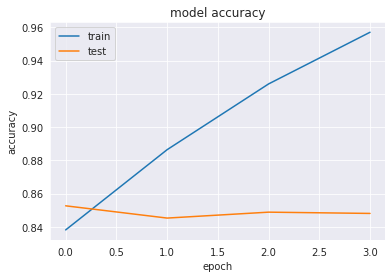

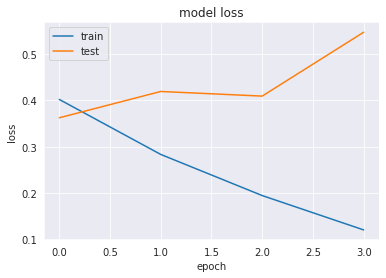

In [ ]:
plot_accuracy(history)

In [ ]:
Y_pred = model.predict(test_dataset.batch(1), batch_size=1)
y_pred = [tf.round(tf.nn.sigmoid(x).numpy().argmax()) for x in Y_pred['logits']]

In [ ]:
print('Classification Report')
target_names = ['real', 'fake']
print(classification_report(y_test.to_list(), y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        real       0.88      0.93      0.90      2944
        fake       0.74      0.61      0.67       984

    accuracy                           0.85      3928
   macro avg       0.81      0.77      0.78      3928
weighted avg       0.84      0.85      0.84      3928



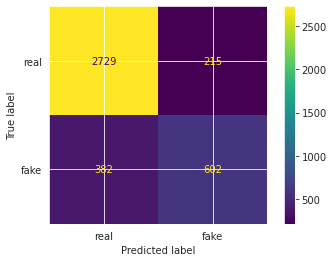

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test.to_list(), y_pred), display_labels=target_names)
disp.plot(values_format='')

In [ ]:
model_summaries['fakenewsnet-gossipcop'] = {'accuracy': history.history['val_accuracy'], 'loss': history.history['val_loss']}

Here, we see the model begin to overfit after the completion of the first epoch.  We achieve a combined accuracy of 85% however the precision, recall, and f1-scores show us that the model suffers particularly with recall of the 'fake' label.

Note that even though performance is not great for the minority class ('fake'), we do achieve substantially higher combined performance using Distilbert than the authors of FakeNewsNet achieved using LR, NB, and CNN methods. https://arxiv.org/pdf/1809.01286.pdf

## **Train with all three datasets combined**

Let's combine all three datasets and train on one larger, more varied corpus.  In addition to the pre-processing performed on our 'main' dataset, after concatenation of our larger corpus, we remove duplicates and also remove text that is shorter than 100 characters.  This is meant to remove erroneous results from the 'scraped' FakeNewsNet dataset.

In [ ]:
all_true = shuffle(pd.concat([true, politifact_true, gossipcop_true]), random_state=42)
all_fake = shuffle(pd.concat([fake, politifact_fake, gossipcop_fake]), random_state=42)
all_data = shuffle(pd.concat([all_true, all_fake]), random_state=42)
all_data.reset_index(drop=True, inplace=True)
all_data = all_data[all_data.text.apply(lambda x: len(str(x)) > 100)]
all_data.drop_duplicates(inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_data.text, all_data.label, test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_list()
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_test.to_list()
))

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16), validation_batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
2854/2854 [==============================] - 1649s 575ms/step - loss: 0.1628 - accuracy: 0.9347 - val_loss: 0.1651 - val_accuracy: 0.9371
Epoch 2/3
2854/2854 [==============================] - 1641s 575ms/step - loss: 0.1148 - accuracy: 0.9555 - val_loss: 0.1328 - val_accuracy: 0.9465
Epoch 3/3
2854/2854 [==============================] - 1641s 575ms/step - loss: 0.0807 - accuracy: 0.9695 - val_loss: 0.1817 - val_accuracy: 0.9417


In [ ]:
model.save_pretrained('/content/saved_tf_model')

Note that the transformers package has its own methods to save and load models.  Using native Tensorflow/Keras methods without using the transformers wrappers will result in an error.

In [ ]:
Y_pred = model.predict(test_dataset.batch(1), batch_size=1)
y_pred = [tf.round(tf.nn.sigmoid(x).numpy().argmax()) for x in Y_pred['logits']]

In [ ]:
print('Classification Report')
target_names = ['real', 'fake']
print(classification_report(y_test.to_list(), y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        real       0.93      0.97      0.95      7151
        fake       0.95      0.89      0.92      4263

    accuracy                           0.94     11414
   macro avg       0.94      0.93      0.94     11414
weighted avg       0.94      0.94      0.94     11414



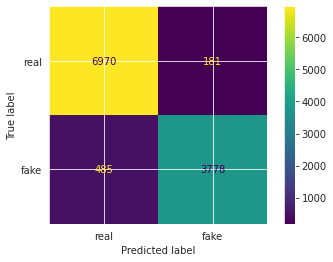

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test.to_list(), y_pred), display_labels=target_names)
disp.plot(values_format='')

In [ ]:
model_summaries['combined-datasets'] = {'accuracy': history.history['val_accuracy'], 'loss': history.history['val_loss']}

We see that the model begins to overfit after the second epoch.  Performance is still worse for the recall of the minority class ('fake') but we now have a model that is more generalizable, having been trained on a larger and more varied corpus while retaining over 90% accuracy, with f1-scores over 90% as well!

## **Explainability**

We use SHAP for explainability.  From the Github page, "SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations)." [Github](https://github.com/slundberg/shap)

In [ ]:
!pip install shap

     |████████████████████████████████| 371 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509248 sha256=bc27a613349ef4c128d1891a130e5e11830f54ab13cc42f85972b04398724701
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


We create a transformers inference pipeline to combine the tokenizer with the model, thus avoiding the need to manually pre-tokenize our input.

In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Using our model for inference is as simple as sending it a list of plaintext sentences, and receiving probabilities.  By using the pipeline, we no longer have to pre-tokenize or convert logits to probabilities.

In [ ]:
pipe(X_test.to_list()[4])

[[{'label': 'LABEL_0', 'score': 0.9997548460960388},
  {'label': 'LABEL_1', 'score': 0.0002452043991070241}]]

We import shap and create an explainer from the pipeline.

In [ ]:
import shap
explain = shap.Explainer(pipe)

We generate Shapley values from our test article.  Since the max token length of our model is 512, it may take some time!

In [ ]:
shap_values = explain([X_test.to_list()[4]])

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [01:42, 102.09s/it]              


Let's view the values as a bar chart, showing which tokens had the most influence on our model.

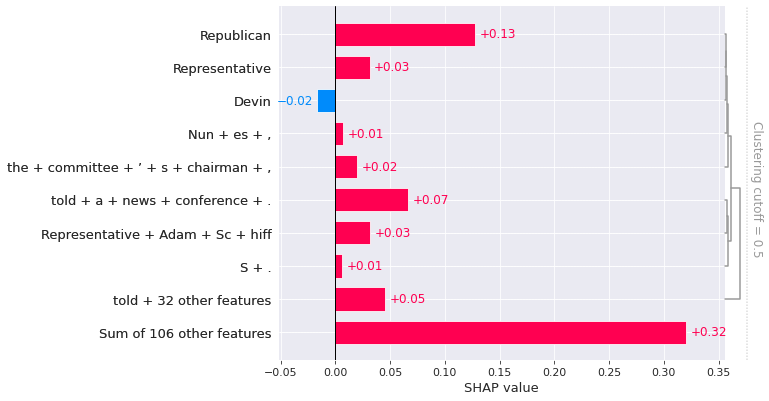

In [ ]:
shap.plots.bar(shap_values[0,:,"LABEL_0"])

To get the full effect of the explanation, let's view our feature importance in-line with the article.

In [ ]:
shap.plots.text(shap_values)

## **Conclusion**

In [ ]:
# compare performance of datasets

## **References**

H. Ahmed, I. Traore and S. Saad, "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques," Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments, vol. 10618, pp. 127-138, 2017.

H. Ahmed, I. Traore and S. Saad, "Detecting opinion spams and fake news using text," Journal of Security and Privacy, vol. 1, no. 1, January/February 2018. 

I. Ahmad, M. Yousaf, S. Yousaf and M. O. Ahmad, "Fake News Detection Using Machine Learning Ensemble Methods," Complexity, 2020. 

K. Shu, D. Mahudeswaran, S. Wang, D. Lee and H. Liu, "FakeNewsNet: A Data Repository with News Content, Social Context, and Spatiotemporal Information for Studying Fake News on Social Media," Big Data, vol. 8, no. 3, pp. 171-188, 1 June 2020. 

R. K. Kaliyar, A. Goswami and P. Narang, "FakeBERT: Fake news detection in social media with a BERT-based deep learning approach," Multimed Tools Appl, vol. 80, pp. 11765-11788, 2021. 

M. H. Goldani, S. Momtazi, R. Safabakhsh and , "Detecting fake news with capsule neural networks," Applied Soft Computing, vol. 101, p. March, 2021.

J. Y. Khan, T. I. Khondaker, S. Afroz, G. Uddin and A. Iqbal, "A benchmark study of machine learning models for online fake news detection," Machine Learning with Applications, vol. 4, 15 June 2021. 

Y. Liu, M. Ott, N. Goyal, J. Du, M. Joshi, D. Chen, O. Levy, M. Lewis, L. Zettlemoyer and V. Stoyanov, "RoBERTa: A Robustly Optimized BERT Pretraining Approach," ArXiv, 2019.

V. Sanh, L. Debut, J. Chaumond and T. Wolf, "DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter," arXiv, 2019.

J. Devlin, M.-W. Chang, K. Lee and K. Toutanova, "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding," in NAACL, 2019. 

huggingface.co, "DistilBERT - transformers 4.12.2 documentation," 2021. [Online]. Available: https://huggingface.co/transformers/model_doc/distilbert.html. [Accessed 11 2021].

K. P. Shung, "Accuracy, Precision, Recall or F1? | Towards Data Science," 15 March 2018. [Online]. Available: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. [Accessed 22 September 2021].

C. Molnar, "9.5 Shapley Values | Interpretable Machine Learning," 2021. [Online]. Available: https://christophm.github.io/interpretable-ml-book/shapley.html. [Accessed 11 2021].


https://huggingface.co/transformers/custom_datasets.html

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html

## **Appendix**

### Appendix A (FakeNewsNet preprocessing code)

Note that this code requires that the FakeNewsNet corpus has already been downloaded via the [Github](https://github.com/KaiDMML/FakeNewsNet) repository.  The scripts provided in the repository linked above will crawl the internet to retrieve active articles from each dataset, and will store each article as a separate JSON file.  The following function will perform preprocessing on the FakeNewsNet dataset to concatenate all individual article files into four files: true.csv and fake.csv for both Politifact and Gossipcop sources.



```
import os
import csv
import json


base_path = os.path.abspath(r'C:\Users\jeff\Code\DAAN570\project\FakeNewsNet\code\fakenewsnet_dataset')
processed_file_path = os.path.abspath(r'C:\Users\jeff\Code\DAAN570\project\data\FakeNewsNet')

for dataset in os.listdir(base_path):
    for label in os.listdir(os.path.join(base_path, dataset)):
        os.makedirs(os.path.join(processed_file_path, dataset), exist_ok = True)
        with open(os.path.join(processed_file_path, dataset, label+'.csv'), 'w', encoding='utf-8', newline='') as csv_file:
            writer = csv.writer(csv_file)
            for item in os.listdir(os.path.join(base_path, dataset, label)):
                try:
                    with open(os.path.join(base_path, dataset, label, item, 'news content.json')) as f:
                        j = json.load(f)
                        writer.writerow([j['title'], j['text']])
                except OSError as e:
                    print(e)
```



### Appendix B (loading a fine-tuned transformers model from disk)

Models should be loaded using the from_pretrained method instead of via native TensorFlow/Keras APIs due to the way some model functions are implemented.  For example, model.compute_loss, a custom loss function, would not import correctly via native APIs.



```
model = TFDistilBertForSequenceClassification.from_pretrained('./saved_tf_model')
```

